# *2D Hard Sphere (Hard Disk) Problem*
`Doruk Efe Gökmen -- 26/07/2018 -- Ankara`

## Event Driven Hard Disks Simulation (Molecular Dynamics Simulation)

Solves the Newtonian dynamics of a 4 hard disk system exactly. Spheres move in straight lines between collisions and the collision events are calculated by finding the minimum of 6 time values until the walls and the other disks.

Note that this algorithm is exact assuming that the numbers for the velocity and the times are calculated with infinite precision. However this is not the case for computers where the numbers are truncated at a finite value. By definition, chaotic systems are characterised by the vas differences in the final states despite having only marginal differences in their initial conditions. Therefore, although the numbers calculated by the molecular dynamics algorithm have millions of digits, the simulation is valid only for a limited number of iterations. (The chaoticity of the system is caused by the negative curvature of the surface of the disk.)

In [22]:
%pylab qt
import os, math, pylab

output_dir = "event_disks_box_movie"
colors = ['r', 'b', 'g', 'orange']

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * (del_x_sq - 4.0 * sigma ** 2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

def min_arg(l):
    return min(zip(l, range(len(l))))

def compute_next_event(pos, vel):
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    return min_arg(wall_times + pair_times)

def compute_new_velocities(pos, vel, next_event_arg):
    if next_event_arg < len(singles):
        collision_disk, direction = singles[next_event_arg]
        vel[collision_disk][direction] *= -1.0
    else:
        a, b = pairs[next_event_arg - len(singles)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2):
            vel[a][k] += e_perp[k] * scal
            vel[b][k] -= e_perp[k] * scal

pylab.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10)
pylab.gcf().set_size_inches(6, 6)
img = 0
if not os.path.exists(output_dir): os.makedirs(output_dir)
def snapshot(t, pos, vel, colors, arrow_scale=.2):
    global img
    pylab.cla()
    pylab.axis([0, 1, 0, 1])
    pylab.setp(pylab.gca(), xticks=[0, 1], yticks=[0, 1])
    for (x, y), (dx, dy), c in zip(pos, vel, colors):
        dx *= arrow_scale
        dy *= arrow_scale
        circle = pylab.Circle((x, y), radius=sigma, fc=c)
        pylab.gca().add_patch(circle)
        pylab.arrow( x, y, dx, dy, fc="k", ec="k", head_width=0.05, head_length=0.05 )
    pylab.text(.5, 1.03, 't = %.2f' % t, ha='center')
    pylab.savefig(os.path.join(output_dir, '%04i.png' % img))
    pylab.pause(0.00001)
    pylab.show()
    img += 1

pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]
singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
sigma = 0.15
t = 0.0
dt = 0.02     # dt=0 corresponds to event-to-event animation
n_steps = 100
next_event, next_event_arg = compute_next_event(pos, vel)
snapshot(t, pos, vel, colors)
for step in range(n_steps):
    pylab.clf()
    if dt:
        next_t = t + dt
    else:
        next_t = t + next_event
    while t + next_event <= next_t:
        t += next_event
        for k, l in singles: pos[k][l] += vel[k][l] * next_event
        compute_new_velocities(pos, vel, next_event_arg)
        next_event, next_event_arg = compute_next_event(pos, vel)
    remain_t = next_t - t
    for k, l in singles: pos[k][l] += vel[k][l] * remain_t
    t += remain_t
    next_event -= remain_t
    snapshot(t, pos, vel, colors)
    #print 'time',t

print('Producing animation.gif using ImageMagick...')
os.system("convert -delay 1 -dispose Background +page " + str(output_dir)
          + "/*.png -loop 0 " + str(output_dir) + "/animation.gif")

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Producing animation.gif using ImageMagick...


32512

## Direct Sampling Hard Disks
By Boltzmann's equiprobability hypothesis and ergodic hypothesis, given infinite time, the system explores all of its possible configurations with equal probability. This key idea leads to the following algorithm that samples possible configurations of 4 hard disk system through direct sampling. For an infinitely large sampling, the resulting frames of the system constitute a "time scrambled" version of the actual dynamics of the system.

In [1]:
%pylab qt
import random, math, os, pylab

output_dir = 'direct_disks_box_movie'

def direct_disks_box(N, sigma):
    condition = False
    while condition == False:
        L = [(random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))]
        for k in range(1, N):
            a = (random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))
            min_dist = min(math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for b in L) 
            if min_dist < 2.0 * sigma: 
                condition = False
                break
            else:
                L.append(a)
                condition = True
    return L

img = 0
if not os.path.exists(output_dir): os.makedirs(output_dir)
def snapshot(pos, colors):
    global img
    pylab.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10)
    pylab.gcf().set_size_inches(6, 6)
    pylab.axis([0, 1, 0, 1])
    pylab.setp(pylab.gca(), xticks=[0, 1], yticks=[0, 1])
    for (x, y), c in zip(pos, colors):
        circle = pylab.Circle((x, y), radius=sigma, fc=c)
        pylab.gca().add_patch(circle)
    #pylab.savefig(os.path.join(output_dir, '%d.png' % img), transparent=True)
    pylab.pause(0.01)
    pylab.show()
    img += 1

N = 4 #the number of disks
colors = ['r', 'b', 'g', 'orange']
sigma = 0.2 #the radii of the disks
n_runs = 8
for run in range(n_runs):
    pos = direct_disks_box(N, sigma)
    snapshot(pos, colors)
    pylab.clf()

Populating the interactive namespace from numpy and matplotlib


Direct sampling with periodic boundary conditions. Notice that for $N=16$ disks of radii $\sigma=\sqrt{\frac{\eta}{\pi N}}$, where $\eta=0.26$ is the density of the disks, it is found that it usually occurred thousands of rejections before producing a legitimate configuration! It turns out that the acceptance ratio in the case of $\eta=0.3$ and $N=16$, the acceptance ratio $p_{\text{acceptance}}=5\times 10^{-6}$. The accepted cases strictly characterise the portion of the $32$-dimensional configuration space that corresponds to the $16$ hard disk system. In other words, the rejection probability can be used to calculate the partition function $Z(\eta)$ of the system.

For a $2$-D box of volume V, the $32$-dimensional configuration space has the volume $V^{16}$. If the radius of the disk is $\sigma=0 \implies \eta=0$, i.e. the density of the box is $0$, then all the points of the configuration space are legal configurations of the system. Hence the partition function of that system is $Z(N,\eta=0)=V^N$. On the other hand $Z(N,\eta)=Z(N,\eta=0)p_{\text{acceptance}}$.

Populating the interactive namespace from numpy and matplotlib
run 0
30036 tabula rasa wipe-outs before producing the following configuration
[(0.5290863088869059, 0.026602165942082534), (0.7068861913834033, 0.841765426057141), (0.350246769636395, 0.5691655942222656), (0.5645476848710024, 0.25386832218349087), (0.04798050921429031, 0.35387875591009954), (0.7908119383793827, 0.016254686601902435), (0.9999214172719869, 0.4952435341395388), (0.14324225234241617, 0.7544997761130654), (0.790845238067139, 0.6926598186347003), (0.6603863557473032, 0.424173085826433), (0.5231276402387884, 0.7180344838877797), (0.3431909675284315, 0.025476194822818043), (0.34948072471303104, 0.3231388243348168), (0.958008437682202, 0.7639663257620449), (0.8479799683835139, 0.35298926296288435), (0.2538594432886999, 0.18606330998718656)]



<Figure size 432x288 with 0 Axes>

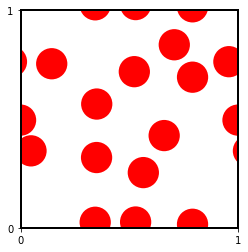

run 1
16547 tabula rasa wipe-outs before producing the following configuration
[(0.820775802536151, 0.6382203875836991), (0.4994876147259021, 0.6944488152203134), (0.8262359021855195, 0.015628632683440946), (0.9371208419822434, 0.8968165824312339), (0.17126203609104784, 0.5847827680049164), (0.14538249802057335, 0.8095048871852456), (0.6514025090157548, 0.24049746233092262), (0.8444344838268607, 0.3206571424503102), (0.4309482077730372, 0.4158203150383223), (0.6118328659936254, 0.4489655140103994), (0.26674751156518983, 0.07280573592629969), (0.3367265167647999, 0.5685097793003173), (0.44624884853100755, 0.8332232581634768), (0.6291172175885347, 0.903243985050751), (0.30286450459953096, 0.29800677302308276), (0.7924321388459232, 0.7967320275977108)]



<Figure size 432x288 with 0 Axes>

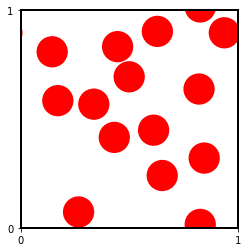

run 2
7516 tabula rasa wipe-outs before producing the following configuration
[(0.997011476912311, 0.23823009873908463), (0.20621709483185124, 0.5891035784239245), (0.10118350467709525, 0.07907699087981945), (0.4716465280346849, 0.417454687405741), (0.4678218946283592, 0.7141723043275596), (0.3147159813855247, 0.7210526639527041), (0.9952703671930787, 0.6922178099114037), (0.35585010258529315, 0.5649069148664847), (0.6609343694723954, 0.5163412127065151), (0.5608111707904527, 0.2627446089358014), (0.24357655441213055, 0.9462511646654779), (0.28150850754722967, 0.3405060330435056), (0.9018256207654266, 0.10565325251846991), (0.6224147643203051, 0.6670379720594759), (0.5510108953783537, 0.0866724260029228), (0.7678616786480671, 0.9479731188795825)]



<Figure size 432x288 with 0 Axes>

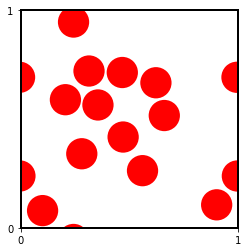

run 3
26138 tabula rasa wipe-outs before producing the following configuration
[(0.9434199654999524, 0.15218440298230407), (0.09745669212185293, 0.6460152193667532), (0.27098153940391645, 0.2922309691987671), (0.3188707740561313, 0.5554249964405475), (0.7312006374701823, 0.7166516747159463), (0.15511726616813903, 0.14901876055716923), (0.9306327850845793, 0.5145610011161166), (0.3417698978206465, 0.7565287669956946), (0.5230768300029479, 0.6176798382811663), (0.5923745591850242, 0.3794954882057897), (0.501353747848843, 0.7822898246983823), (0.37901538349632535, 0.12374150475647527), (0.002423264837273287, 0.3230211686176111), (0.20415136567818648, 0.8777440359462632), (0.8520738693427051, 0.8339903634866587), (0.8022041186441675, 0.05433996145526898)]



<Figure size 432x288 with 0 Axes>

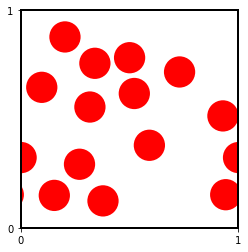

run 4
6084 tabula rasa wipe-outs before producing the following configuration
[(0.7590878221547396, 0.38609759080933814), (0.7785486579710811, 0.5892174114517533), (0.5732064268778967, 0.3005173238565446), (0.5168950312242604, 0.7537428959811848), (0.4195615209396405, 0.9178446574429164), (0.20762995655358862, 0.5829254689199423), (0.765030883264898, 0.8155794809216419), (0.33782792836027997, 0.33804887534482286), (0.16593128400739898, 0.9556577252452482), (0.1015162527233131, 0.3432614494975966), (0.20573498888013464, 0.7501051776901527), (0.9916406419116316, 0.5596533897780842), (0.4981527878862717, 0.4537827964280835), (0.6059255756849841, 0.10226042014195891), (0.13771319471837562, 0.15787588170708022), (0.38774080885250817, 0.16451894627990304)]



<Figure size 432x288 with 0 Axes>

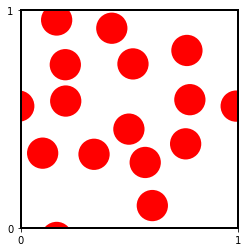

In [4]:
%pylab inline
import random, math, pylab, os

#Introduce the periodic boundary conditions via the modular distance function between two 2D vectors x, y:
def dist(x,y):
    d_x = abs(x[0] - y[0]) % 1.0 #distance between the first compononents of two vectors in modulo 1
    d_x = min(d_x, 1.0 - d_x) #the modular distance is the minimum of cases due to periodicity
    d_y = abs(x[1] - y[1]) % 1.0 #distance between the second compononents of two vectors in modulo 1
    d_y = min(d_y, 1.0 - d_y)
    return  math.sqrt(d_x**2 + d_y**2) #returns the modular distance
    
def direct_disks(N, sigma): #constructs a legal sample in the 2N-dimensional unit hypercube
    n_iter = 0
    condition = False
    while condition == False:
        n_iter += 1 #increases in the case of failure to find non-overlapping disk coordinates
        L = [(random.random(), random.random())] #random vector in 2N-dimensional hypercube
        for k in range(1, N):
            a = (random.random(), random.random()) #random vector in the 2D square
            min_dist = min(dist(a, b) for b in L) #minimum of the distances between any two disks
    #if the modular distance between any two disks is less than their radii, then breaks and tries again
            if min_dist < 2.0 * sigma:
                condition = False
                break
            else:
                L.append(a) #if no overlap occurs, then adds a new disk with coordinates a to the system
                condition = True
    return n_iter, L #the number of iterations required to find a legal configuration and its coordinates

img = 0
output_dir = 'direct_disks_multirun_movie'
if not os.path.exists(output_dir): os.makedirs(output_dir)
def snapshot(pos, colors, border_color = 'k'):
    global img
    pylab.figure()
    pylab.axis([0, 1, 0, 1])
    [i.set_linewidth(2) for i in pylab.gca().spines.itervalues()]
    [i.set_color(border_color) for i in pylab.gca().spines.itervalues()]
    pylab.setp(pylab.gca(), xticks = [0, 1], yticks = [0, 1], aspect = 'equal')
    for (x, y), c in zip(pos, colors):
        circle = pylab.Circle((x, y), radius = sigma, fc = c)
        pylab.gca().add_patch(circle)
    pylab.savefig(output_dir+'/snapshot_%03i.png'%img)
    pylab.pause(0.001)
    pylab.close()
    img += 1

def periodicize(config):
    images = [-1.0, 0.0, 1.0]
    return [(x + dx, y + dy) for (x,y) in config for dx in images for dy in images]

N = 16 #the number of the disks
eta = 0.26 #the disk density of the system (fraction of space occupied by the disks)
sigma = math.sqrt(eta / N / math.pi) #the radii of the disks
n_runs = 5 #number of runs
colors = ['r' for i in range(8 * N)]
for run in range(n_runs):
    pylab.clf()
    iterations, config =  direct_disks(N, sigma)
    print 'run',run
    print iterations - 1, 'tabula rasa wipe-outs before producing the following configuration'
    print config
    print 
    config_per = periodicize(config)
    snapshot(config_per, colors, border_color = 'k')

The acceptance probability $p_{\text{acceptance}}(\eta)$ is calculated by the following code.

Populating the interactive namespace from numpy and matplotlib


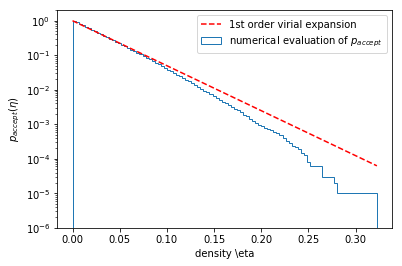

In [10]:
%pylab inline
import random, math, pylab

def dist(x, y): #periodic boundary conditions as before
    d_x = abs(x[0] - y[0]) % 1.0
    d_x = min(d_x, 1.0 - d_x)
    d_y = abs(x[1] - y[1]) % 1.0
    d_y = min(d_y, 1.0 - d_y)
    return  math.sqrt(d_x**2 + d_y**2)
    
N = 16 #number of disks
n_confs = 10 ** 5 #number of configurations
pairs = [(i, j) for i in range(N - 1) for j in range(i + 1, N)]
eta_max_list = [] #initialise the allowed maximum densities
for conf in xrange(n_confs):
    #sample a random configuration -- overlapping/non-overlapping
    #i.e. pick a random vector in 2N-D unit hypercube
    L = [(random.random(), random.random()) for k in range(N)]
    #determine the maximum possible radius so that any of the two disks in the configuration overlap
    sigma_max = min(dist(L[i], L[j]) for i, j in pairs) / 2.0 
    eta_max = N * math.pi * sigma_max ** 2 #calculate the corresponding maximum density
    eta_max_list.append(eta_max)
    #The histogram of these maximum densities corresponds to the acceptance probability!

# Begin of graphics output
pylab.figure()
n, bins, patches = pylab.hist(eta_max_list, 100, histtype='step', cumulative=-1, 
                   log=True, normed=True, label="numerical evaluation of $p_{accept}$")
explaw = [math.exp( - 2.0 * (N - 1) * eta) for eta in bins] #first term in Virial expansion
pylab.plot(bins, explaw, 'r--', linewidth=1.5, label="1st order virial expansion")
pylab.xlabel('density \eta')
pylab.ylabel('$p_{accept}(\eta)$')
pylab.legend()
pylab.show()

## Markov-Chain Sampling Hard Disks
Direct sampling for hard disks works only at low densities and small particle numbers, and we thus switch to a more general Markov-chain Monte Carlo algorithm. Similar approach as direct sampling but this time the sampling is done through the Markov-chains, i.e. the location of a particular disk is updated from where it was at the previous frame. The rejection cases are the cases where any two of the disks overlap. The necessary conditions are aperiodicity and irreducibility. Aperiodicity is trivial in this case. Here, reducibility corresponds to the case where the radii of the disks are so large, so that they stuck and vibrate at their initial locations. There, the system can be reduced into four independent systems. Hence, irreducibility is a condition on the size of the radii of the disks.

There is a link between the acceptance probability of the system and the partition function as seen in the previous section.

Populating the interactive namespace from numpy and matplotlib


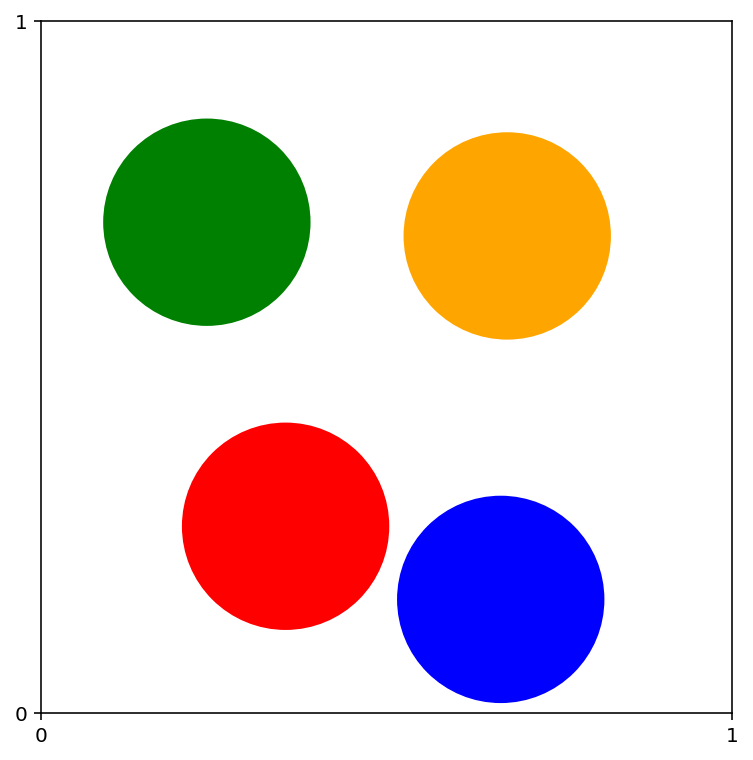

In [5]:
%pylab qt
import random, os, pylab

output_dir = 'markov_disks_box_movie'

img = 0
if not os.path.exists(output_dir): os.makedirs(output_dir)
def snapshot(pos, colors):
    global img
    pylab.subplots_adjust(left=0.10, right=0.90, top=0.90, bottom=0.10)
    pylab.gcf().set_size_inches(6, 6)
    pylab.axis([0, 1, 0, 1])
    pylab.setp(pylab.gca(), xticks=[0, 1], yticks=[0, 1])
    for (x, y), c in zip(pos, colors):
        circle = pylab.Circle((x, y), radius=sigma, fc=c)
        pylab.gca().add_patch(circle)
    #pylab.savefig(os.path.join(output_dir, '%d.png' % img), transparent=True)
    pylab.pause(0.0001)
    pylab.show()
    img += 1

L = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]] #initial positions of the disks
sigma = 0.15 #the radii of disks
sigma_sq = sigma ** 2
delta = 0.1
colors = ['r', 'b', 'g', 'orange']
n_steps = 50
for step in range(n_steps):
    pylab.clf()
    snapshot(L, colors)
    a = random.choice(L)
    b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
    min_dist = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a) 
    box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
    if not (box_cond or min_dist < 4.0 * sigma ** 2):
        a[:] = b

The "tabula rasa" strategy explained:

In [6]:
import random

N = 4
sigma = 0.2 #the radii of disks
pairs = [(i, j) for i in range(N - 1) for j in range(i + 1, N)]
while True:
    #place four disks at randomly chosen positions: uniform vector in an 8D hypercube
    L = [(random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma)) for k in range(N)]
    #check for an overlap between the disks by calculating the distance in between all disks
    if  min((L[i][0] - L[j][0]) ** 2 + (L[i][1] - L[j][1]) ** 2 for i, j in pairs) > 4.0 * sigma ** 2: 
        break #if overlap occurs, the algorithm breaks
print L #Sample coordinates of the four disks are outputted

[(0.3029469955941781, 0.7670627214525076), (0.7129377088143414, 0.7693773660570689), (0.32291343374765724, 0.2737530107568247), (0.7867778045636022, 0.25558665751782333)]


On the other hand, it is crucial to note that *random sequential deposition* is forbidden since it yields inequal probabilities. The following example illustrates this in a 1D discrete example where two rods are placed on a grid of size 5.

In [1]:
%pylab qt
import random, pylab, os

output_dir = 'random_sequential_discrete_movie'
if not os.path.exists(output_dir): os.makedirs(output_dir)
def show_rods(red_rod, blue_rod, run, trial, frame):
    fig, ax = pylab.subplots()
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_yticks([])
    height = 1.0
    redrect = pylab.Rectangle((red_rod - 1.5, 0.0), 3.0, 1.1 * height,  fc = 'r')
    pylab.gca().add_patch(redrect)
    bluerect = pylab.Rectangle((blue_rod-1.5,0.0), 3.0, height,  fc = 'b')
    pylab.gca().add_patch(bluerect)
    pylab.axis('scaled')
    pylab.axis([-1.5, 5.5, 0.0, 2.5*height])
    pylab.xlabel("x")
    if abs(red_rod - blue_rod) > 2:
        pylab.title('run %d, trial %d (ACCEPTED!)' % (run, trial))
    else:
        pylab.title('run %d, trial %d (REJECTED!)' % (run, trial))
    pylab.savefig(output_dir+'/random_sequential_discrete_frame%04i.png' % (frame))
    pylab.pause(0.0001)
    pylab.close()

configurations = {(0, 3): 'a', (0, 4): 'b', (1, 4): 'c', 
                  (3, 0): 'd', (4, 0): 'e', (4, 1): 'f'}
counts = {'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': 0}
n_runs = 10
frame = 0
trial = 0
for run in range(n_runs):
    pylab.clf()
    red_rod = random.randint(0, 3)
    if red_rod >= 2: red_rod += 1
    trial = 0
    while True:
        blue_rod = random.randint(0, 4)
        show_rods(red_rod, blue_rod, run, trial, frame)
        trial += 1
        frame += 1
        if abs(red_rod - blue_rod) > 2: break
    conf = configurations[(red_rod, blue_rod)]
    counts[conf] += 1
for conf in counts:
    print conf, counts[conf] / float(n_runs)

Populating the interactive namespace from numpy and matplotlib
a 0.1
c 0.2
b 0.0
e 0.0
d 0.4
f 0.3


## Equiprobability
![caption](equiprob.png)

Using small boxes [x - del_xy, x + del_xy], etc, we can show that the probability to sample the following "marked" configurations a, b, and c (given in the code) are the same (within the numerical precision), with the following codes for direct sampling, Markov-chain sampling, and simulation of Newtonian mechanics via the event driven algorithm.

### Direct sampling:

In [3]:
import random, math
def direct_disks_box(N, sigma): #same direct sampling as in the second section
    condition = False
    while condition == False:
        L = [(random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))]
        for k in range(1, N):
            a = (random.uniform(sigma, 1.0 - sigma), random.uniform(sigma, 1.0 - sigma))
            min_dist = min(math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2) for b in L)
            if min_dist < 2.0 * sigma:
                condition = False
                break
            else:
                L.append(a)
                condition = True
    return L

sigma = 0.15 #radius
del_xy = 0.05 #"uncertainty"
n_runs = 1000000

#Define the "marked" configurations:
conf_a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
conf_b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
conf_c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))
configurations = [conf_a, conf_b, conf_c] #list the configurations

hits = {conf_a: 0, conf_b: 0, conf_c: 0} #initialise the number of times each marked configuration occurs

for run in range(n_runs):
    x_vec = direct_disks_box(4, sigma) #generates a random sample by direct sampling
    for conf in configurations: #run a loop iterating over the given 3 configurations
    #condition that a randomly generated configuration L is the same as a, b or c up to uncertainty of del_xy
        condition_hit = True
        for b in conf: #run a loop iterating over the 4 disk coordinates in a specific configuration
            #If the max(x distance and y distance between a disk in L and a disk in conf_a,b,c) 
            #is less than the given uncertainty del_xy, then we treat the two disks as in the same location.
            #Note that the "any two disks" condition is realised by minimising over all 4 disks in a 
            #randomly sampled configuration L.
            condition_b = min(max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in x_vec) < del_xy  
            #The following logical variable is 1 only if there exists 4 disk pairs are within del_xy range.
            #If at least any one of the disks does not have a pair within del_xy, then it is 0.
            condition_hit *= condition_b #multiplies condition_b's (for all 4 disks)
        #If the current L and a, b or c are the same up to uncertainty del_xy, then increase:
        if condition_hit:
            hits[conf] += 1

for conf in configurations:
    print conf, hits[conf] #Print the configurations and the number of times they occured.

((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 110
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 114
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 115


### Markov-chain sampling:

In [13]:
import random

def markov_disks_box(L, delta, sigma):
    condition = True
    while condition == True:
        a = random.choice(L)
        b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
        min_dist = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a)
        box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
        if not (box_cond or min_dist < 4.0 * sigma ** 2):
            a[:] = b
            condition = False
            break
    return L

#inputs of the markov_disks_box function:
#initial positions of the disks to startup the Markov-chain
L = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]] 
delta = 0.1
sigma = 0.15 #radius

n_steps = 10000
del_xy = 0.05 #"uncertainty"

#Define the "marked" configurations:
conf_a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
conf_b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
conf_c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))
configurations = [conf_a, conf_b, conf_c] #list the configurations

hits = {conf_a: 0, conf_b: 0, conf_c: 0} #initialise the number of times each marked configuration occurs

for run in range(n_steps):
    x_vec = markov_disks_box(L, delta, sigma) #generates a random sample by direct sampling
    for conf in configurations: #run a loop iterating over the given 3 configurations
    #condition that a randomly generated configuration L is the same as a, b or c up to uncertainty of del_xy
        condition_hit = True
        for b in conf: #run a loop iterating over the 4 disk coordinates in a specific configuration
            #If the max(x distance and y distance between a disk in L and a disk in conf_a,b,c) 
            #is less than the given uncertainty del_xy, then we treat the two disks as in the same location.
            #Note that the "any two disks" condition is realised by minimising over all 4 disks in a 
            #randomly sampled configuration L.
            condition_b = min(max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in x_vec) < del_xy  
            #The following logical variable is 1 only if there exists 4 disk pairs are within del_xy range.
            #If at least any one of the disks does not have a pair within del_xy, then it is 0.
            condition_hit *= condition_b #multiplies condition_b's (for all 4 disks)
        #If the current L and a, b or c are the same up to uncertainty del_xy, then increase:
        if condition_hit:
            hits[conf] += 1

for conf in configurations:
    print conf, hits[conf] #Print the configurations and the number of times they occured.

((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 3
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 1
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 0


### Newtonian dynamics

In [12]:
import math, pylab

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

conf_a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
conf_b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
conf_c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))
configurations = [conf_a, conf_b, conf_c]
hits = {conf_a: 0, conf_b: 0, conf_c: 0}
del_xy = 0.10
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]
singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
sigma = 0.10
t = 0.0
n_events = 5000000
for event in range(n_events):
    if event % 100000 == 0:
        print event
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    next_event = min(wall_times + pair_times)
    t_previous = t
    for inter_times in range(int(t + 1), int(t + next_event + 1)):
        del_t = inter_times - t_previous
        for k, l in singles:
            pos[k][l] += vel[k][l] * del_t
        t_previous = inter_times
        #print t "Configuration analysis is done"
        for conf in configurations:
            condition_hit = True
            for b in conf:
                condition_b = min(max(abs(a[0] - b[0]), abs(a[1] - b[1])) for a in pos) < del_xy
                condition_hit *= condition_b
            if condition_hit:
                hits[conf] += 1
    t += next_event
    del_t = t - t_previous
    for k, l in singles:
        pos[k][l] += vel[k][l] * del_t
    if min(wall_times) < min(pair_times):
        collision_disk, direction = singles[wall_times.index(next_event)]
        vel[collision_disk][direction] *= -1.0
    else:
        a, b = pairs[pair_times.index(next_event)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2):
            vel[a][k] += e_perp[k] * scal
            vel[b][k] -= e_perp[k] * scal
            
print t, "The total running time of the program"

for conf in configurations:
    print conf, hits[conf]

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
611527.898476
((0.3, 0.3), (0.3, 0.7), (0.7, 0.3), (0.7, 0.7)) 668
((0.2, 0.2), (0.2, 0.8), (0.75, 0.25), (0.75, 0.75)) 690
((0.3, 0.2), (0.3, 0.8), (0.7, 0.2), (0.7, 0.7)) 655


### Calculations in terms of observables

Instead of the configurations themselves, and their probability distribution, we now consider an observable, in fact a particularly simple one, the position x: the x-coordinate of the center of a disk. We will compute its probability distribution, as the normed histogram of x-positions. This histogram is the same for all disks, so we can collect data for one disk or for all of them.

*Direct sampling:* 

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


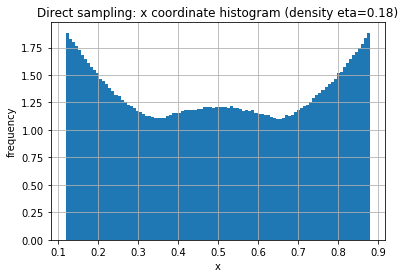

In [14]:
%pylab inline
import random, pylab

N = 4
sigma = 0.1197
n_runs = 1000000

histo_data = []
for run in range(n_runs):
    pos = direct_disks_box(N, sigma) #this function was defined in the previous section
    for k in range(N):
        histo_data.append(pos[k][0])
pylab.hist(histo_data, bins=100, normed=True)
pylab.xlabel('x')
pylab.ylabel('frequency')
pylab.title('Direct sampling: x coordinate histogram (density eta=0.18)')
pylab.grid()
pylab.savefig('direct_disks_histo.png')
pylab.show()

*Markov-chain sampling:*

Populating the interactive namespace from numpy and matplotlib


/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


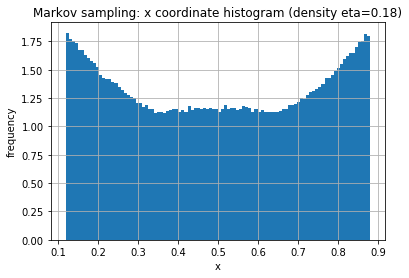

In [7]:
%pylab inline
import random, pylab

L = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]] 
delta = 0.2 #may need to be varied
sigma = 0.1197
N=4

n_steps = 2000000

histo_data = []
for steps in range(n_steps):
    pos = markov_disks_box(L, delta, sigma) #this function was defined in the previous section
    for k in range(N):
        histo_data.append(pos[k][0])
pylab.hist(histo_data, bins=100, normed=True)
pylab.xlabel('x')
pylab.ylabel('frequency')
pylab.title('Markov sampling: x coordinate histogram (density eta=0.18)')
pylab.grid()
pylab.savefig('markov_disks_histo.png')
pylab.show()

*Event drivent Newtonian dynamics:*

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
485918.792042 The total running time of the program


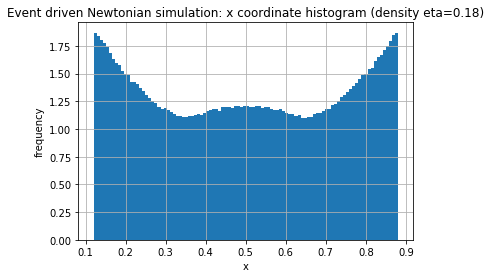

In [9]:
import math, pylab

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

#define the marked conditions
conf_a = ((0.30, 0.30), (0.30, 0.70), (0.70, 0.30), (0.70,0.70))
conf_b = ((0.20, 0.20), (0.20, 0.80), (0.75, 0.25), (0.75,0.75))
conf_c = ((0.30, 0.20), (0.30, 0.80), (0.70, 0.20), (0.70,0.70))
configurations = [conf_a, conf_b, conf_c]

#initial conditions
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]] 
vel = [[0.21, 0.12], [0.71, 0.18], [-0.23, -0.79], [0.78, 0.1177]]

singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

sigma = 0.1197 #radius
n_events = 5000000 

t = 0.0 #initialise time
histo_data = [] #initialise histogram
for event in range(n_events):
    if event % 100000 == 0:
        print event
    wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
    pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
    next_event = min(wall_times + pair_times)
    t_previous = t
    for inter_times in range(int(t + 1), int(t + next_event + 1)):
        del_t = inter_times - t_previous
        for k, l in singles:
            pos[k][l] += vel[k][l] * del_t
        t_previous = inter_times
        
        #histogram update
        for k in range(N):
            histo_data.append(pos[k][0]) #take the histogram of the x (0th) coordinate
        
    t += next_event
    del_t = t - t_previous
    for k, l in singles:
        pos[k][l] += vel[k][l] * del_t
    if min(wall_times) < min(pair_times):
        collision_disk, direction = singles[wall_times.index(next_event)]
        vel[collision_disk][direction] *= -1.0
    else:
        a, b = pairs[pair_times.index(next_event)]
        del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
        abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
        e_perp = [c / abs_x for c in del_x]
        del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
        scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
        for k in range(2):
            vel[a][k] += e_perp[k] * scal
            vel[b][k] -= e_perp[k] * scal
            
print t, "The total running time of the program"

#figure output
pylab.hist(histo_data, bins=100, normed=True)
pylab.xlabel('x')
pylab.ylabel('frequency')
pylab.title('Event driven Newtonian simulation: x coordinate histogram (density eta=0.18)')
pylab.grid()
pylab.savefig('event_disks_histo.png')
pylab.show()

We see that event driven Newtonian dynamics, direct and Markov-chain sampling give the same histogram for the x-position of the disks. *This is a hint for the equivalence between statistical mechanics and Newtonian mechanics.*